# ZAD 1

Proszę, korzystając z algorytmu roju cząstek znaleźć minimum funkcji

$f(x,y)= 2ln(|𝑥+0.2|+0.002)+ln(|y+0.1|+0.001)+ cos(3x)+2sin^2(3xy)+sin^2(y)-x^2-0.5y^2 $

w przedziale $𝑥, 𝑦 ∈ [-1,1]$,  


przy założeniu że rozwiązanie jest reprezentowane przez wektor [𝑥𝑖, 𝑦𝑖].

Proszę zbadać:
- funkcjonowanie algorytmu dla c1=0, c2=2
- funkcjonowanie algorytmu dla c1=2, c2=0 oraz kilku przypadków pośrednich.
- funkcjonowanie algorytmu dla c1 = c2 = 2,2
- funkcjonowanie dla różnych wartości w.


Za każdym razem należy podać średnie wyniki (wartość funkcji przystosowania) oraz odchylenie standardowe dla 10 wywołań algorytmu i przedstawić przykładowe przebiegi algorytmu na wykresach (dla jednego z wywołań).

Należy opisać, który wariant sprawdzał się najlepiej.

In [127]:
!pip install -q plotly

In [128]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
import pandas as pd

In [129]:
def glob_func(*args):
  args = args[0]
  return 2*np.log(np.abs(args[0]+0.2)+0.002)+np.log(np.abs(args[1]+0.1)+0.001)+np.cos(3*args[0])+2*(np.sin(3*args[0]*args[1]))**2+(np.sin(args[1]))**2-args[0]**2-0.5*args[1]**2

In [130]:
x = np.linspace(-1, 1, 200)
y = np.linspace(-1, 1, 200)
X, Y = np.meshgrid(x, y)
Z = np.array([glob_func([x_, y_]) for x_, y_ in zip(X.ravel(), Y.ravel())]).reshape(X.shape)
surface = go.Surface(z=Z, x=X, y=Y, colorscale='Viridis')
fig = go.Figure(data=[surface])
fig.update_layout(
    title='Wykres funkcji',
    scene=dict(
        xaxis_title='x',
        yaxis_title='y',
        zaxis_title='f(x, y)'
    ),
    width=800,
    height=600
)
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [131]:
def pso(cost_func, dim=2, num_particles=30, max_iter=30, w=0.5, c1=1, c2=2):
    # Inicjalizacja pozycji i prędkości cząstek
    particles = np.random.uniform(-1, 1, (num_particles, dim)) # kazda czasteczka to losowy punkt x,y gdzie x, y naleza do przedzialu odpowiedniego
    velocities = np.zeros((num_particles, dim)) # dla kazdej czasteczki mamy dwuwymiarowy wektor

    best_positions = np.copy(particles)   # kopia aktualnych pozycji
    best_fitness = np.array([cost_func(list(p)) for p in particles])  # aktualne wartosci funkcji dla tych czasteczek
    swarm_best_position = best_positions[np.argmin(best_fitness)] # zwraca polozenie czasteczki ktora jest w najmiejszej wartosci funkcji
    swarm_best_fitness = np.min(best_fitness) # zwraca ta najmniejsza wartosc funkcji dla zbioru czasteczek
    #print(f'{(swarm_best_position - particles)=}')
    # print(f'{particles=}')
    # print(f'{best_positions=}')
    # print(f'{best_fitness=}')
    # print(f'{swarm_best_position=}')
    # print(f'{swarm_best_fitness=}')

    # Listy do śledzenia historii optymalizacji
    avgs = []           # średnia wartość funkcji w każdej iteracji
    bests_fitness = []  # najlepsza wartość funkcji w każdej iteracji

    # Główna pętla optymalizacji
    for i in range(max_iter):
        # dostajemy macierze o wymiarach: num_particles, dim i wartosciach [0,1)
        r1 = np.random.rand(num_particles, dim)
        r2 = np.random.rand(num_particles, dim)

        # Aktualizacja prędkości cząstek
        velocities = (
            w * velocities
            + c1 * r1 * (best_positions - particles)  # pozycje - aktualne pozycje
            + c2 * r2 * (swarm_best_position - particles) # najlepsza pozycja, czyli polozenie [wektor 2d] - polozenia wszystkich czasteczek pokolei
              # czyli tutaj dostajemy takie 'odchylenia' kazdej z czasteczek
        )

        # Aktualizacja pozycji
        particles += velocities

        # Ocena funkcji celu
        fitness_values = np.array([cost_func(p) for p in particles])

        # Aktualizacja najlepszych pozycji lokalnych
        improved = fitness_values < best_fitness  # zwraca wartosci true albo false w odpowiednich indeksach
        #print(f'{improved=}')
        # dla tych indeksow zamieniamy ktore sie polepszyly, zmieniamy wartosci zaktualizowane funkcji oraz polozenia
        best_positions[improved] = particles[improved]
        best_fitness[improved] = fitness_values[improved]

        # Aktualizacja najlepszej pozycji globalnej
        if np.min(fitness_values) < swarm_best_fitness:
            swarm_best_position = particles[np.argmin(fitness_values)]
            swarm_best_fitness = np.min(fitness_values)

        # Zapis statystyk do historii
        avgs.append(np.mean(fitness_values))  # srednia wartosc funkcji dla aktualnych najlepszych czasteczek
        bests_fitness.append(swarm_best_fitness)  # najlepsza wartosc funkcji dla aktualnych czasteczek

    return swarm_best_position, swarm_best_fitness, particles, avgs, bests_fitness


In [132]:
def run_pso(c1_v=1, c2_v=2, w_v=0.5, num_runs=10, want_3D_plot = False, want_plots = True):
  best_solutions = []
  for i in range(num_runs):
    swarm_best_position, swarm_best_fitness, final_particles, avgs, bests_fitness = pso(glob_func, c1=c1_v, c2 = c2_v)
    #chcemy sredni wynik dla kazdej iteracji oraz odchylenie standardowe wartosci funkcji
    #stds.append(np.std([glob_func(particle) for particle in final_particles]))
    best_solutions.append(swarm_best_fitness)
    #print(f'{swarm_best_fitness=}')
    if i == 6 and want_plots:
      fig, axs = plt.subplots(1, 2, figsize=(10, 4))
      axs[0].plot(avgs, label='Średnia wartość', linewidth=2)
      axs[0].set_title("Średnia wartość funkcji przystosowania na iterację")
      axs[0].set_xlabel("Iteracja")
      axs[0].set_ylabel("Średnia wartość")
      axs[0].grid(True)
      axs[0].legend()

      axs[1].plot(bests_fitness, label='Najlepsza wartość', color='orange', linewidth=2)
      axs[1].set_title("Najlepsza wartość funkcji przystosowania na iterację")
      axs[1].set_xlabel("Iteracja")
      axs[1].set_ylabel("Najlepsza wartość")
      axs[1].grid(True)
      axs[1].legend()

      plt.tight_layout()
      plt.show()

      ## additional feature
      if want_3D_plot:
        x = np.linspace(-1, 1, 200)
        y = np.linspace(-1, 1, 200)
        X, Y = np.meshgrid(x, y)
        Z = np.array([glob_func([x_, y_]) for x_, y_ in zip(X.ravel(), Y.ravel())]).reshape(X.shape)

        surface = go.Surface(z=Z, x=X, y=Y, colorscale='Viridis', opacity=0.7)

        particles_scatter = go.Scatter3d(
            x=final_particles[:, 0],
            y=final_particles[:, 1],
            z=[glob_func(p) for p in final_particles],
            mode='markers',
            marker=dict(size=3, color='black'),
            name='       Cząstki (ostatnia iteracja)'
        )
        best_point = go.Scatter3d(
            x=[swarm_best_position[0]],
            y=[swarm_best_position[1]],
            z=[swarm_best_fitness],
            mode='markers',
            marker=dict(size=6, color='red'),
            name='       Najlepsze rozwiązanie'
        )

        fig = go.Figure(data=[surface, particles_scatter, best_point])
        fig.update_layout(
            title='Funkcja z cząstkami PSO',
            scene=dict(
                xaxis_title='x',
                yaxis_title='y',
                zaxis_title='f(x, y)'
            ),
            width=800,
            height=600
        )
        fig.show()
        ## additional feature

  avg_best_solution = np.mean(best_solutions)
  std = np.std(best_solutions)

  print(f'FOR:\n\t C1 = {c1_v}\n\t C2 = {c2_v}\n\t W = {w_v}')
  print(f'Average best solution: {avg_best_solution}')
  print(f'Standard Deviation: {std}')
  print('-'*100)

  return min(best_solutions)

## Wyniki dla różnych C1, C2

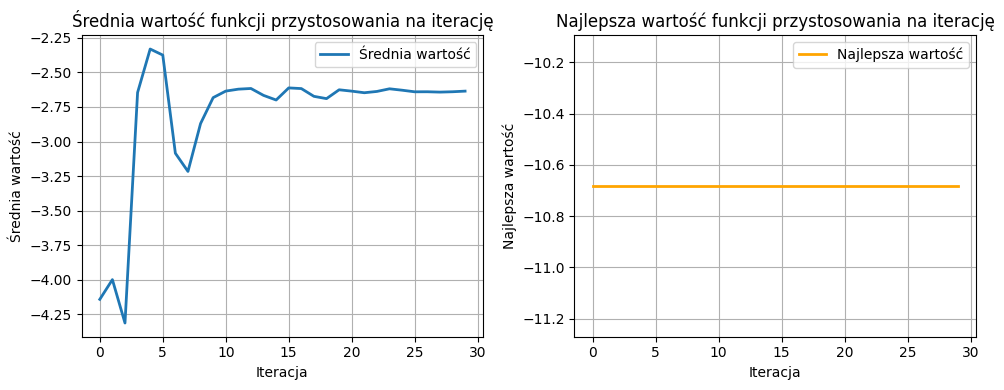

FOR:
	 C1 = 0
	 C2 = 2
	 W = 0.5
Average best solution: -13.635130340792381
Standard Deviation: 3.042162441376038
----------------------------------------------------------------------------------------------------


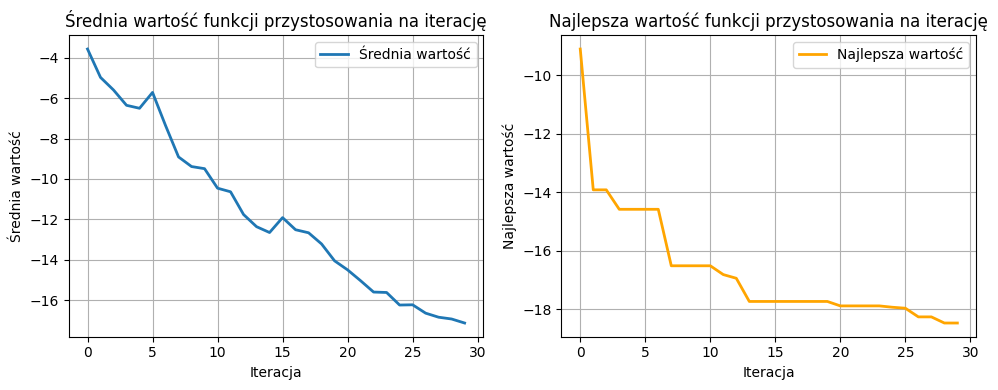

FOR:
	 C1 = 1
	 C2 = 2
	 W = 0.5
Average best solution: -352883201.9741931
Standard Deviation: 1045643353.0626359
----------------------------------------------------------------------------------------------------


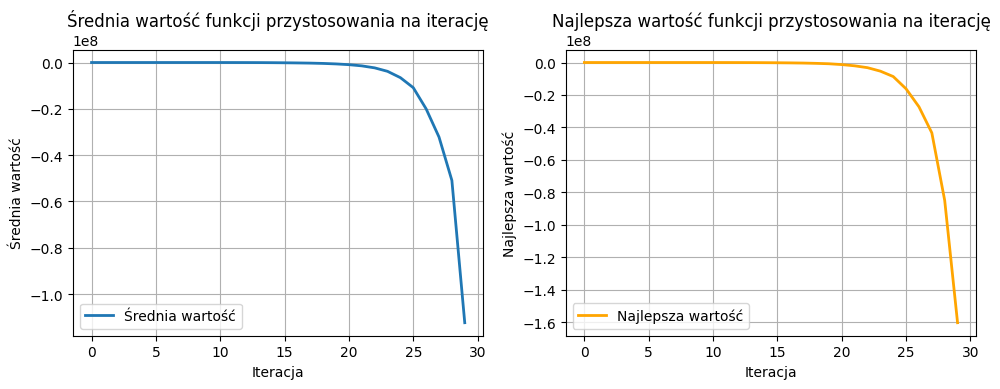

FOR:
	 C1 = 2
	 C2 = 2
	 W = 0.5
Average best solution: -196932384.98923376
Standard Deviation: 343446373.4056141
----------------------------------------------------------------------------------------------------


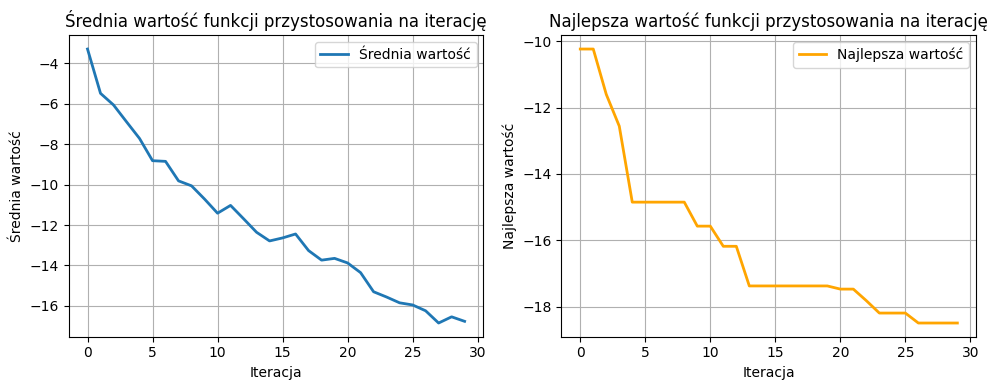

FOR:
	 C1 = 2
	 C2 = 1
	 W = 0.5
Average best solution: -18.34251803502357
Standard Deviation: 0.15501155899566174
----------------------------------------------------------------------------------------------------


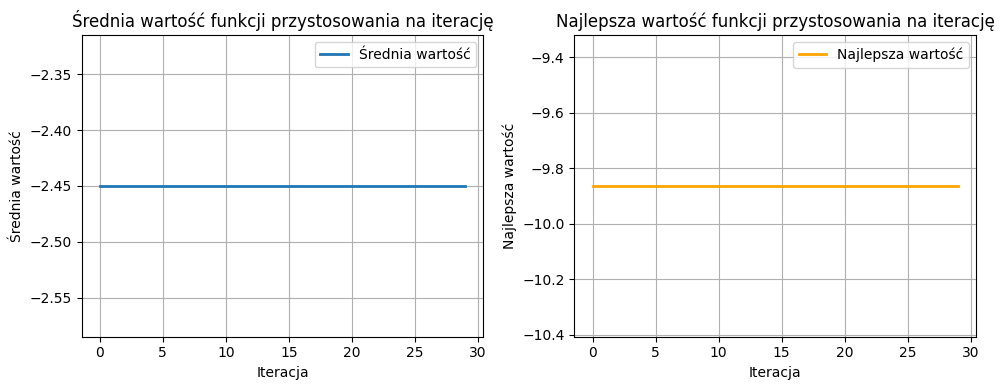

FOR:
	 C1 = 2
	 C2 = 0
	 W = 0.5
Average best solution: -8.159658231071031
Standard Deviation: 1.9804858797616016
----------------------------------------------------------------------------------------------------


In [140]:
c_i_values = [[0,2],[1,2],[2,2],[2,1],[2,0]]
for c_i in c_i_values:
  run_pso(c1_v = c_i[0], c2_v = c_i[1])

## Wnioski C1, C2
Dla współczynnika inercji ustawionego na 0.5 przeprowadziłam analizę funkcjonowania algorytmu dla różnych wartości C1, C2.  
Dla [C1, C2] = [0, 2] mamy dobry przykład utknięcia w minimum lokalnym. Składnik społeczny jest duży, podczas, gdy składnik poznawczy jest zerowy. Cząsteczki ignorują własne doświadczenie.  
Dla [C1, C2] = [2, 0] jest na odwrót, każda cząsteczka wieruje się wyłącznie swoim własnym najlepszym rozwiązaniem. Cząsteczki się nie komunikują. Również tutaj nie znaleźliśmy globalnego minimum, a bardziej średnie najlepsze minimum, na podstawie najlepszych od każdej cząsteczki. Cząsteczki tutaj działały niezależnie.    
Dla [C1, C2] = [2,2] dostajemy wynik wykraczający poza zakres badań. Wysokie wartości obu współczynników, spowodowały większe przyspieszanie. Wektory prędkości zwiększały się o zbyt duże wartości. Jak widzimy funkcja rośnie na granicach dziedziny. Być może to również było przyczyną 'wystrzelenia' wyników. Podobnie, ale na mniejszą skalę, dzieje się dla [C1, C2] = [1,2]. Dla obu tych przypadków wartości odchylenia standardowego są ogromne. Świadczy to o niestabiloności algorytmu.
Dla [C1, C2] = [2,1] dostajemy najlepszy wynik ok. -18.22, bliski minimum globalnemu funkcji. Najwyraźniej naljepiej dla tego problemu jest, gdy cząsteczka pobiera więcej informacji od samej siebie, ale również ważne są informacje globalne.


### Wyniki dla różnych wag dla optymalnych wartości C1, C2

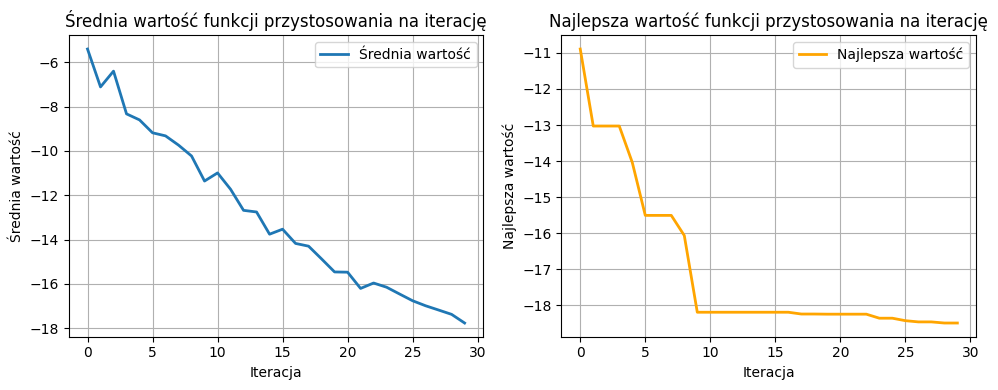

FOR:
	 C1 = 2
	 C2 = 1
	 W = 0.2
Average best solution: -18.440640418221726
Standard Deviation: 0.08164615239588945
----------------------------------------------------------------------------------------------------


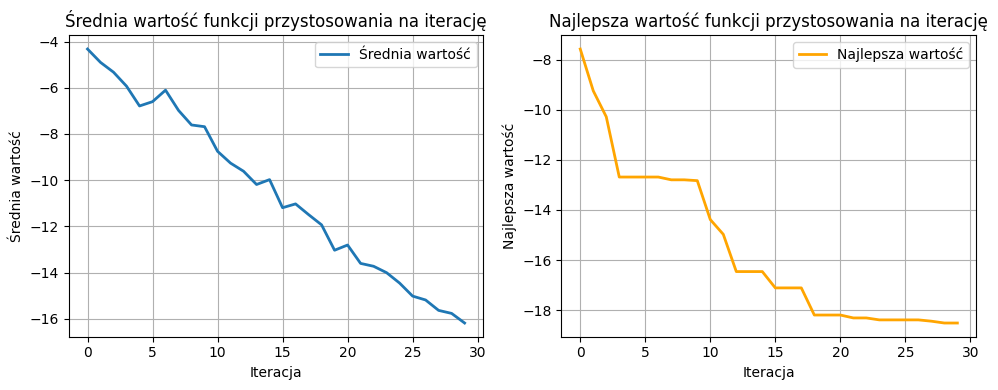

FOR:
	 C1 = 2
	 C2 = 1
	 W = 0.3
Average best solution: -18.3723570307093
Standard Deviation: 0.14317502720515385
----------------------------------------------------------------------------------------------------


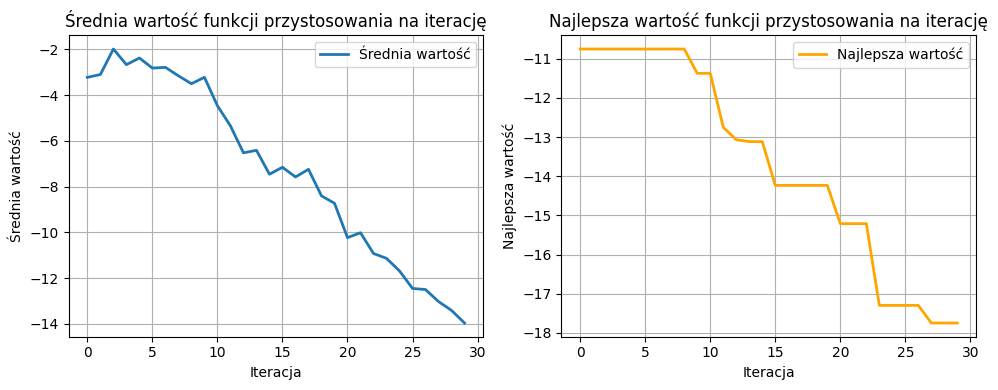

FOR:
	 C1 = 2
	 C2 = 1
	 W = 0.5
Average best solution: -18.278581722858668
Standard Deviation: 0.27281434015149075
----------------------------------------------------------------------------------------------------


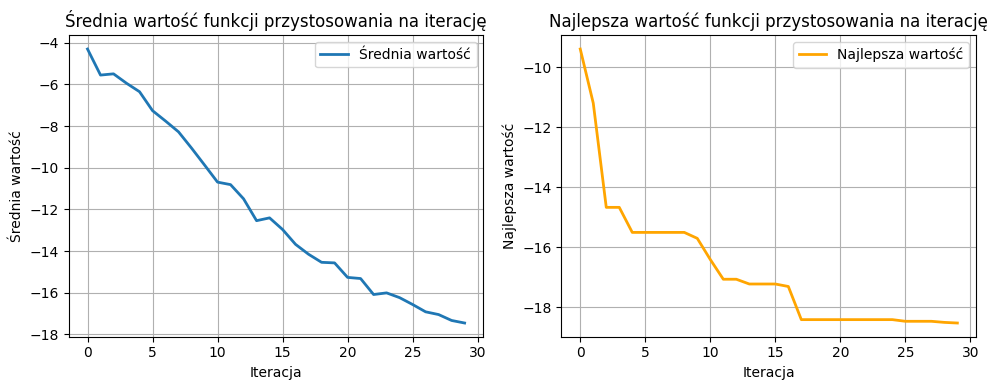

FOR:
	 C1 = 2
	 C2 = 1
	 W = 0.7
Average best solution: -18.410164486747057
Standard Deviation: 0.13226516900072288
----------------------------------------------------------------------------------------------------


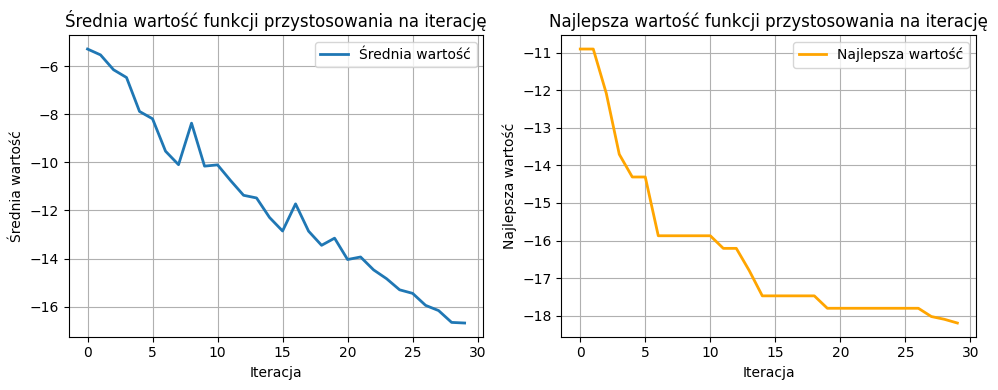

FOR:
	 C1 = 2
	 C2 = 1
	 W = 0.9
Average best solution: -18.262340972281343
Standard Deviation: 0.14335371131742447
----------------------------------------------------------------------------------------------------


In [144]:
w_values = [0.2, 0.3, 0.5, 0.7, 0.9]
for w in w_values:
  run_pso(c1_v = 2, c2_v = 1, w_v = w)

## Wnioski
Najlepszy wynik zwraca algorytm z wagą: 0.2

## Przykładowy wynik działania dla najlepszych parametrów: C1 = 2, C2 = 1, W = 0.2


In [148]:
import time
times = []
mins = []
for _ in range(10):
  start = time.time()
  min_overal = run_pso(c1_v = 2, c2_v = 1, w_v = 0.2, want_plots=False)
  mins.append(min_overal)
  end = time.time()
  times.append(end - start)

FOR:
	 C1 = 2
	 C2 = 1
	 W = 0.2
Average best solution: -18.367721850640592
Standard Deviation: 0.17317428760182296
----------------------------------------------------------------------------------------------------
FOR:
	 C1 = 2
	 C2 = 1
	 W = 0.2
Average best solution: -18.4044439880713
Standard Deviation: 0.12443011225262508
----------------------------------------------------------------------------------------------------
FOR:
	 C1 = 2
	 C2 = 1
	 W = 0.2
Average best solution: -18.39332487356044
Standard Deviation: 0.19799564495391914
----------------------------------------------------------------------------------------------------
FOR:
	 C1 = 2
	 C2 = 1
	 W = 0.2
Average best solution: -18.17801435644696
Standard Deviation: 0.31064797052210724
----------------------------------------------------------------------------------------------------
FOR:
	 C1 = 2
	 C2 = 1
	 W = 0.2
Average best solution: -18.36774544300261
Standard Deviation: 0.25936754786100674
---------------------

In [152]:
print(f'Minimalna znaleziona wartosc funkcji: {np.min(mins)}')
print(f'Czas wykonania: {end - start} s')

Minimalna znaleziona wartosc funkcji: -18.53354902642709
Czas wykonania: 0.11413931846618652 s


## Wnioski
Na wykresie końcowym algorytmu o optymalnie dobranych parametrach: C1, C2, w, widzimy, że znaleźliśmy minimalną wartość funkcji: ok. -18.53 w czasie średnio: 0.11 sekund.

# ZAD 2
Uzyskany najlepszy wynik proszę w miarę możliwości porównać z algorytmem genetycznym – dedykowanym dla optymalizacji tej samej funkcji. Zakładamy użycie takiej samej liczby epok dla obu algorytmów.
Należy porównać czas działania obydwu algorytmów.

In [137]:
GENES_LENGTH = 16

class Solution:
    def __init__(self):
      """ Osobnik sklada sie [x_genes, y_genes] """
      self.genes = [0] * (GENES_LENGTH * 2)
      self.genes = [random.randint(0, 1) for _ in range(GENES_LENGTH * 2)]

    def decode(self):
      def bin_to_real(gene):
          int_val = int("".join(str(bit) for bit in gene), 2)
          return -1. + (int_val / (2**GENES_LENGTH - 1)) * (1. - (-1.))

      x_genes = self.genes[:GENES_LENGTH]
      y_genes = self.genes[GENES_LENGTH:]
      x = bin_to_real(x_genes)
      y = bin_to_real(y_genes)
      return x, y

    def get_adaptation(self):
      x,y = self.decode()
      z = glob_func((x,y))
      return -z

    def crossover(self, other):
      cut_position = random.randint(0, len(self.genes) - 1)
      child = Solution()
      child.genes = self.genes[:cut_position] + other.genes[cut_position:]
      return child

    def mutate(self, mutation_chance=0.01):
        for i in range(len(self.genes)):
            if random.random() < mutation_chance:
                self.genes[i] = 1 - self.genes[i]

In [138]:
import random
# liczba epok ta sama: max_iter = 30
def run_algorithm(selection_type, mutation_chance=0.3, population_size = 50, iterations = 30, print_details=True, show_plots = False):
  population = [Solution() for _ in range(population_size)]
  best_solution = None
  best_solution_adaptation = -float('inf')

  avgs = []
  bests_local = []
  bests_global = []

  for iteration in range(iterations):
      adaptations = [p.get_adaptation() for p in population]

      local_best = max(population, key=lambda p: p.get_adaptation())
      if local_best.get_adaptation() > best_solution_adaptation:
          best_solution = local_best
          best_solution_adaptation = local_best.get_adaptation()

      avgs.append(sum(adaptations) / len(adaptations))
      bests_local.append(max(adaptations))
      bests_global.append(best_solution_adaptation)

      if selection_type == 'roulette':
        roulette_wheel = adaptations
        for i in range(len(roulette_wheel)):
          roulette_wheel[i] -= min(adaptations)
          roulette_wheel[i] /= (max(adaptations)-min(adaptations))

        parents = [random.choices(population, weights=roulette_wheel, k=2) for _ in range(population_size)]
        children = [p1.crossover(p2) for p1, p2 in parents]
      else:
        threshold_value = round(int(selection_type[-2:])/100*population_size)
        best_candidates = sorted(population, key=lambda x: x.get_adaptation(), reverse=True)[:threshold_value]
        parents = [random.choices(best_candidates, k=2) for i in range(population_size)]
        children = [p[0].crossover(p[1]) for p in parents]

      for child in children:
          child.mutate(mutation_chance)
      population = children


  final_adaptations = [p.get_adaptation() for p in population]
  final_best = max(population, key=lambda p: p.get_adaptation())
  if final_best.get_adaptation() > best_solution_adaptation:
      best_solution = final_best
      best_solution_adaptation = final_best.get_adaptation()

  if print_details:
      x, y = best_solution.decode()
      print("---")
      print(f"Najlepsze rozwiązanie: x = {x:.6f}, y = {y:.6f}")
      print(f"Wartość funkcji: f(x, y) = {-best_solution_adaptation:.6f}")

  if show_plots:
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.plot(avgs); plt.title("Średnie przystosowanie")
        plt.subplot(1, 3, 2)
        plt.plot(bests_local); plt.title("Najlepszy osobnik w iteracji")
        plt.subplot(1, 3, 3)
        plt.plot(bests_global); plt.title("Najlepszy globalnie")
        plt.tight_layout(); plt.show()

  return best_solution, -best_solution_adaptation

In [153]:
times = []
mins = []
for i in range(10):
  start = time.time()
  best_solution, best_solution_adaptation = run_algorithm('threshold_10',mutation_chance = 0.1,show_plots=False)
  end = time.time()
  times.append(end-start)
  mins.append(best_solution_adaptation)
print(f'Czas wykonania: {np.mean(times)} s')
print(f'Minimum znalezione: {np.min(mins)}')

---
Najlepsze rozwiązanie: x = -0.200000, y = -0.100267
Wartość funkcji: f(x, y) = -18.302735
---
Najlepsze rozwiązanie: x = -0.199939, y = -0.099870
Wartość funkcji: f(x, y) = -18.357309
---
Najlepsze rozwiązanie: x = -0.200000, y = -0.100023
Wartość funkcji: f(x, y) = -18.516842
---
Najlepsze rozwiązanie: x = -0.203174, y = -0.100145
Wartość funkcji: f(x, y) = -16.509585
---
Najlepsze rozwiązanie: x = -0.200000, y = -0.100053
Wartość funkcji: f(x, y) = -18.487436
---
Najlepsze rozwiązanie: x = -0.200000, y = -0.100053
Wartość funkcji: f(x, y) = -18.487436
---
Najlepsze rozwiązanie: x = -0.200244, y = -0.099779
Wartość funkcji: f(x, y) = -18.109791
---
Najlepsze rozwiązanie: x = -0.200122, y = -0.100328
Wartość funkcji: f(x, y) = -18.137427
---
Najlepsze rozwiązanie: x = -0.199878, y = -0.099565
Wartość funkcji: f(x, y) = -18.059762
---
Najlepsze rozwiązanie: x = -0.199176, y = -0.099992
Wartość funkcji: f(x, y) = -17.840211
Czas wykonania: 0.11056647300720215 s
Minimum znalezione: -1

## Wnioski
Wybrałam algorytm genetyczny dla kodowania binarnego. Po przetestowaniu parametrów, najlepsze wyniki zwracał algorytm o typie selekcji threshold_10 dla prawdopodobieństwa mutacji 0.1. Algorytm zwraca wyniki zbliżone do algorytmu pso, jednak delikatnie gorsze. Na przykładzie widzimy, że algorytm wyliczył minimum globalne ok.: -18.51. Dodatkowo działa on w czasie porównywalnym (ok. 0.11 sekund) do algorytmu pso. Porównane zostały średnie czasy z wykonania algorytmów 10-krotnie.